# Sentiment Analysis on Amazon Fine Food Reviews Dataset

Note: Since we are working on google colab, we need to mount google drive in order to save & load files from google drive. For the rest of the code, the files are loaded from my personal google drive path. Reset this if necessary.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')  # Google drive path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import relevant packages and libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Text cleaning
import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords  # stopwords
from nltk import word_tokenize     # tokenisation
from nltk.corpus import wordnet    # lemmatisation
from nltk.stem import WordNetLemmatizer  # lammatiser from WordNet
from collections import Counter
import itertools

# Word cloud
from wordcloud import WordCloud
from collections import defaultdict

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# TF-IDF vector representation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning
from sklearn.naive_bayes import MultinomialNB

# Deep learning
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras import regularizers

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, auc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Data pre-processing

In [0]:
# Read in the dataset
df = pd.read_csv('/content/gdrive/My Drive/ST449-two-class/Reviews.csv')
# Use only score and text columns
df = df[['Score', 'Text']]
# Redefine column names
df['reviews'] = df['Text']
df['rating'] = df['Score']
df.drop(['Score', 'Text'], axis = 1, inplace = True)

# Check if there is any duplicated text and remove
df.drop_duplicates(subset = ['reviews', 'rating'], keep = 'first', inplace = True)
df1 = df.reset_index(drop=True).copy()

In [0]:
# Get indices for which rating equals 3
index_number = df1[df1.rating == 3].index
# Delete these row indices from dataFrame
df1.drop(index_number, axis = 0, inplace=True)
df_without_neutral = df1.reset_index(drop = True).copy()
# Check if there is any null column
print(df_without_neutral.isnull().sum())

reviews    0
rating     0
dtype: int64


In [0]:
# Relabel ratings into postive and negative classes
negative = 0
positive = 1

sentiment = []

for rate in df_without_neutral['rating']:
    if rate >= 4:
        sentiment.append(positive)
    else:
        sentiment.append(negative)

sentiment_df = pd.DataFrame(sentiment, columns = ['sentiment'])
df2 = pd.concat([df_without_neutral, sentiment_df], axis=1)
df2.drop(['rating'], axis = 1, inplace = True)

Class Counts
1    306819
0     57084
Name: sentiment, dtype: int64


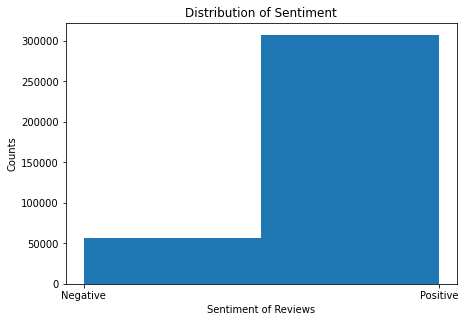

In [0]:
# Check number of samples in each class
print("Class Counts")
print(df2.sentiment.value_counts())

# Plot histogram of number of samples in each class
plt.figure(figsize=(7,4.8))
plt.hist(df2['sentiment'], bins = 2)
plt.xticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Sentiment of Reviews')
plt.ylabel('Counts')
plt.title('Distribution of Sentiment')
plt.show()

In [0]:
# Downsample majority class
positive_class = df2[df2['sentiment'] == 1]
negative_class = df2[df2['sentiment'] == 0]
pos_downsample = resample(positive_class, replace = False, n_samples = len(negative_class), random_state = 123)

# Reset indices
pos_downsample = pos_downsample.reset_index(drop = True).copy()

# Concatenate two classes to form a new data frame
df3 = pd.concat([pos_downsample, negative_class])
df3 = df3.sample(frac = 1, random_state = 1)
df3 = df3.reset_index(drop = True).copy()

# Check if there are null values
print(df3.isnull().sum())

reviews      0
sentiment    0
dtype: int64


Class Counts
1    57084
0    57084
Name: sentiment, dtype: int64


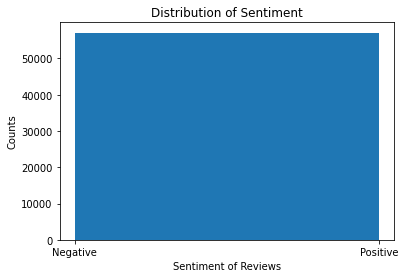

In [0]:
# Check if data frame is balanced
print("Class Counts")
print(df3.sentiment.value_counts())

# Plot histogram of number of samples in each class
plt.hist(df3['sentiment'], bins = 2, align= 'mid')
plt.xticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Sentiment of Reviews')
plt.ylabel('Counts')
plt.title('Distribution of Sentiment')
plt.show()

Text Cleaning

In [0]:
# %load appos.py
# Load contracted words list
# %load appos.py
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

# Customise stopwords list
stop_words = set(stopwords.words('english'))

# Remove negation words that are in NLTK stopwords list
not_stopwords = {'not', 'no'} 
customised_stopwords = set([word for word in stop_words if word not in not_stopwords])

In [0]:
# Lemmertisation
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts.
    (source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/) 
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Define cleaning function

def clean_data(text):
    text = text.lower().split()   # Lowercase and split
    negation_split = [appos[word] if word in appos else word for word in text]    # Negation handling
    text = " ".join(negation_split)
    
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)   # Removing HTML tags
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # Removing any non-english characters
    text = re.sub(r'[?|!|\'|"|#|&|_]', r'', text)   # Removing Punctuations
    text = re.sub(r'[.|,|)|(|\|/|;]', r'', text)  # Removing Punctuations
    text = ''.join(c for c in text if not c.isdigit())  #Removing Numbers
    
    lemmatiser = WordNetLemmatizer()  # Lemmatisation
    word_lemmatise = [lemmatiser.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
      
    word_tokens = [w for w in word_lemmatise if not w in customised_stopwords]   # Removing Stopwords
    
    cleaned_review =" ".join(word_tokens)
    
    return cleaned_review

In [0]:
# Apply clean_data function to all reviews on the data frame
clean_df = pd.DataFrame(df3['reviews'].apply(clean_data))
# Name the clean reviews column
clean_df = clean_df.rename(columns = {'reviews' : 'clean_reviews'})
# Concatenate the clean reviews with dataframe before cleaning
new_df = pd.concat([df3, clean_df], axis = 1)

# Save dataframe to csv
new_df.to_csv('/content/gdrive/My Drive/ST449-two-class/clean-reviews-dataframe.csv', header = True, index = False)

# Reload clean reviews dataframe
new_df1 = pd.read_csv('/content/gdrive/My Drive/ST449-two-class/clean-reviews-dataframe.csv')

In [0]:
# Print an example of the review and clean review
print('An example of review before text cleaning:\n', df3.reviews[13])
print('An example of review after text cleaning:\n', new_df1.clean_reviews[13])

An example of review before text cleaning:
 The product was exactly as stated in the description.  It came on time and I'm very satisfied with the purchase.  It also came out much cheaper buying this product in bulk.
An example of review after text cleaning:
 product exactly state description come time I satisfied purchase also come much cheaper buying product bulk


## Train-test split

In [0]:
# Train-test split
train, test = train_test_split(new_df1, test_size = 0.2, shuffle = True, random_state = 1)
train = train.reset_index(drop = True).copy()
test = test.reset_index(drop = True).copy()

# Train-validation split
train, validation = train_test_split(train, test_size = 0.2, shuffle = True, random_state = 1)
train = train.reset_index(drop = True).copy()
validation = validation.reset_index(drop = True).copy()

# Extract reviews and sentiment
trainX = train['clean_reviews']
trainY = train['sentiment']
testX = test['clean_reviews']
testY = test['sentiment']
validX = validation['clean_reviews']
validY = validation['sentiment']

# Print the shape of each dataset
print(train.shape)
print(test.shape)
print(validation.shape)

(73067, 3)
(22834, 3)
(18267, 3)


Maximum number of tokens per review among all reviews:  1072
Average number of tokens per reviews:  41.76568081349994
Number of reviews that have length less than 100:  68456
Number of reviews that have length more than 100:  4611


Text(0.5, 1.0, 'Distribution of Word Counts')

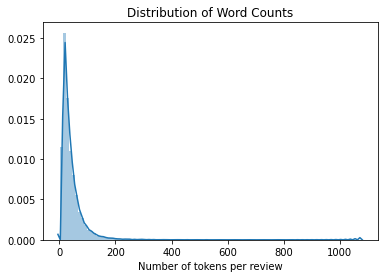

In [0]:
# See the length of reviews
train['token_length'] = [len(x.split(" ")) for x in train.clean_reviews]   # Number of words per review
print("Maximum number of tokens per review among all reviews: ", max(train.token_length))
print("Average number of tokens per reviews: ", np.mean(train.token_length))
print("Number of reviews that have length less than 100: ", Counter(train['token_length'] <= 100)[1])
print("Number of reviews that have length more than 100: ", Counter(train['token_length'] <= 100)[0])

# Plot of the word tokens distribution
sns.distplot(train.token_length, bins = 100, axlabel = 'Number of tokens per review').set_title("Distribution of Word Counts")

### Generate word clouds

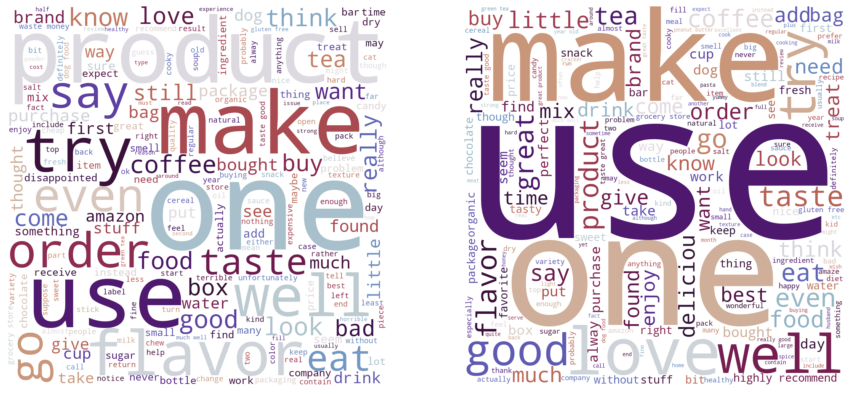

In [0]:
# Define the function
def generate_wordcloud(text):
    all_text = ' '.join(sent for sent in text)
    wordcloud = WordCloud(colormap = 'twilight_r', width = 1000, height = 1000, mode = 'RGBA', background_color = 'white').generate(all_text)
    return wordcloud

wordclouds = []
fig = plt.figure(figsize=(15,15))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    sentiment_class = train[train.sentiment == i]
    wordcloud = generate_wordcloud(sentiment_class.clean_reviews)
    wordclouds.append(wordcloud)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.margins(x=0, y=0)

## Machine learning method

#### TF-IDF (Sparse vector representation)

In [0]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(trainX)
trainX_tfidf = Tfidf_vect.transform(trainX)
testX_tfidf = Tfidf_vect.transform(testX)

#### One-hot representation of labels

In [0]:
# Define function for one-hot representation of labels
def one_hot_label(sentiment):
    return np_utils.to_categorical(np.asarray(sentiment), num_classes = 2)

train_label = one_hot_label(train.sentiment)
test_label = one_hot_label(test.sentiment)
validation_label = one_hot_label(validation.sentiment)

#### Confusion matrix

In [0]:
# Define plotting function for confusion matrix
def plot_confusion_matrix(confusion_mat):
    sentiment_name = ['Negative', 'Positive']
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(confusion_mat, annot = True, fmt = 'd', cbar = False,  cmap="YlGnBu",
            xticklabels = sentiment_name, yticklabels = sentiment_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

### Navie Bayes

In [0]:
nb = MultinomialNB()
nb.fit(trainX_tfidf, trainY)
nb_train_prediction = nb.predict(trainX_tfidf)
nb_train_accuracy = accuracy_score(nb_train_prediction, trainY)
nb_test_prediction = nb.predict(testX_tfidf)
nb_test_accuracy = accuracy_score(nb_test_prediction, testY)
print("Accuracy rate for training data: %.4f " % nb_train_accuracy)
print("Accuracy rate for testing data: %.4f " % nb_test_accuracy)

Accuracy rate for training data: 0.8906 
Accuracy rate for testing data: 0.8571 


              precision    recall  f1-score   support

           0       0.85      0.86      0.86     11264
           1       0.86      0.85      0.86     11570

    accuracy                           0.86     22834
   macro avg       0.86      0.86      0.86     22834
weighted avg       0.86      0.86      0.86     22834



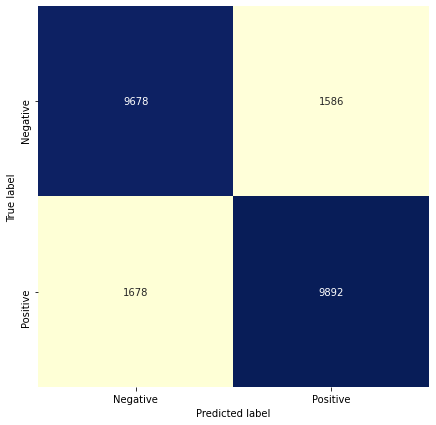

In [0]:
# Metrics for navie Bayes model
print(classification_report(testY, nb_test_prediction))

# Plot confusion matrix
nb_mat = confusion_matrix(testY, nb_test_prediction)
plot_confusion_matrix(nb_mat)

Text(0.5, 0, 'False Positive Rate')

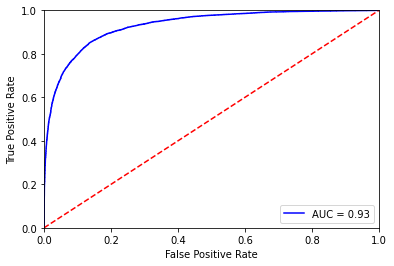

In [0]:
# Plot ROC curve for navie Bayes classifier
nb_test_prob = nb.predict_proba(testX_tfidf)
nb_prediction_prob = nb_test_prob[:,1]
fpr, tpr, threshold = roc_curve(testY, nb_prediction_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Deep learning models

### Define some functions to use later

In [0]:
# Plot training and validation loss
def plot_history_loss(history):
  plt.plot(history.history['loss'], 'r')
  plt.plot(history.history['val_loss'], 'b')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

# Plot training and validation accuracy
def plot_history_accuracy(history):
  plt.plot(history.history['accuracy'], 'r')
  plt.plot(history.history['val_accuracy'], 'b')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Define model checkpoint to save models
def callback_best_model(checkpoint_name):
  path_dirname = "/content/gdrive/My Drive/ST449-two-class/"                 # Define model path
  checkpoint_path = os.path.join(path_dirname, checkpoint_name)
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_best_only=True, verbose=1)
  return cp_callback

# Evaluate training, validation and testing accuracy and loss
def accuracy_loss_evaluation(model):
    loss_train, acc_train = model.evaluate(train_seq, train_label, verbose = 1)
    loss_valid, acc_valid = model.evaluate(valid_seq, validation_label, verbose = 1)
    loss_test, acc_test = model.evaluate(test_seq, test_label, verbose = 1)

    print("Training accuracy: {:5.2f}%, training loss: {:5.2f}".format(100*acc_train, loss_train))
    print("Validation accuracy: {:5.2f}%, validation loss: {:5.2f}".format(100*acc_valid, loss_valid))
    print("Test accuracy: {:5.2f}%, test loss: {:5.2f}".format(100*acc_test, loss_test))

    return loss_train, acc_train, loss_valid, acc_valid, loss_test, acc_test

### Word embedding using GloVe

In [0]:
# Load embedding into memory
embeddings_index = dict()
f = open('/content/gdrive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Dense Vector Representation

In [0]:
# Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['clean_reviews'].values)
vocab_size = len(tokenizer.word_index) + 1                # Number of features

# Create embedding matrix
embedding_dim = 100                                       # Embedding_vector_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

# Create padded sequence of length 100 for train, validation and test sets
train_encoder = tokenizer.texts_to_sequences(train['clean_reviews'].values)
train_seq = pad_sequences(train_encoder, maxlen = 100)                      # Maximum number of words to use in each review is 100
valid_encoder = tokenizer.texts_to_sequences(validation['clean_reviews'].values)
valid_seq = pad_sequences(valid_encoder, maxlen = 100)
test_encoder = tokenizer.texts_to_sequences(test['clean_reviews'].values)
test_seq = pad_sequences(test_encoder, maxlen = 100)

### MLP with random embedding initialization

In [0]:
# Create model instance and define model structure
seq_model = Sequential()
seq_model.add(Embedding(vocab_size, embedding_dim, input_length = 100, trainable = False))   # Embedding layer
seq_model.add(Flatten())                                                                     # Flatten layer
seq_model.add(Dense(64, activation= 'relu'))                                                 # Dense layer
seq_model.add(Dense(2, activation = 'sigmoid'))
# Compile the model
seq_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(seq_model.summary())

# Define hyperparameters
n_epochs = 20
batch_size = 128

# Train the model
history_seq = seq_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                            validation_data = (valid_seq, validation_label), verbose = 1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          5635700   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 6,275,894
Trainable params: 640,194
Non-trainable params: 5,635,700
_________________________________________________________________
None
Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 4s 51us/step - loss: 0.6351 - accuracy: 0.6353 - val_loss: 0.6217 - val_accuracy: 0.6442
Epoch 2/20
73067/73067 [==========

22834/22834 [==============================] - 1s 45us/step
Training accuracy: 86.49%, training loss:  0.29
Validation accuracy: 67.64%, validation loss:  1.07
Test accuracy: 67.79%, test loss:  1.06


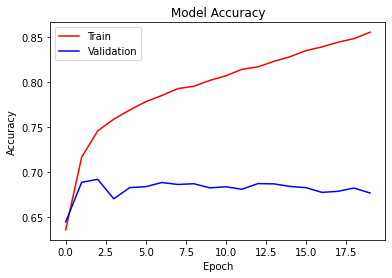

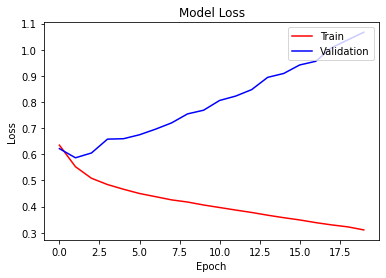

In [0]:
# Evaluate model
seq_loss_train, seq_acc_train, seq_loss_valid, seq_acc_valid, seq_loss_test, seq_acc_test = accuracy_loss_evaluation(seq_model)
# Plot accuracy during training
plot_history_accuracy(history_seq)
# Plot loss during training
plot_history_loss(history_seq)

### MLP with pre-trained Glove

In [0]:
# Create model instance and define model structure
glove_model = Sequential()
glove_model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = 100, trainable = False))
glove_model.add(Flatten())
glove_model.add(Dense(64, activation = 'relu'))
glove_model.add(Dense(2, activation = 'sigmoid'))

# Compile the model
glove_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Print model structure
print(glove_model.summary())

# Define hyperparameters
n_epochs = 20
batch_size = 128

# Train the model
history_glove = glove_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                            validation_data = (valid_seq, validation_label), verbose = 1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          5635700   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 6,275,894
Trainable params: 640,194
Non-trainable params: 5,635,700
_________________________________________________________________
None
Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 4s 52us/step - loss: 0.4939 - accuracy: 0.7570 - val_loss: 0.4669 - val_accuracy: 0.7788
Epoch 2/20
73067/73067 [==========

22834/22834 [==============================] - 1s 43us/step
Training accuracy: 99.98%, training loss:  0.00
Validation accuracy: 76.50%, validation loss:  1.67
Test accuracy: 76.86%, test loss:  1.67


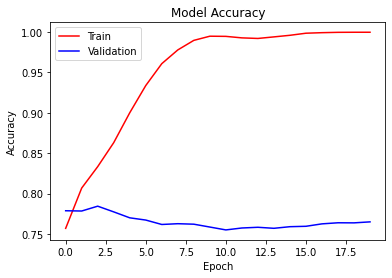

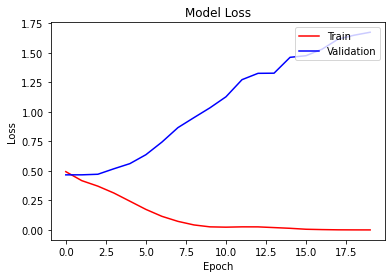

In [0]:
# Evaluate the model
accuracy_loss_evaluation(glove_model)
# Plot accuracy during training
plot_history_accuracy(history_glove)
# Plot loss during training
plot_history_loss(history_glove)

### MLP with GloVe and dropout layers

In [0]:
# Create model instance and define model structure
d_model = Sequential()
d_model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = 100, trainable = False))
d_model.add(Dropout(0.3))  # Dropout layer
d_model.add(Flatten())
d_model.add(Dense(64, activation = 'relu'))
d_model.add(Dropout(0.5))  # Dropout layer
d_model.add(Dense(2, activation = 'sigmoid'))

# Compile the model
d_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define hyperparameters
n_epochs = 20
batch_size = 128

# Train the model
history_d = d_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                            validation_data = (valid_seq, validation_label), verbose = 1)

Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 5s 67us/step - loss: 0.5622 - accuracy: 0.7057 - val_loss: 0.4847 - val_accuracy: 0.7710
Epoch 2/20
73067/73067 [==============================] - 5s 65us/step - loss: 0.5050 - accuracy: 0.7520 - val_loss: 0.4704 - val_accuracy: 0.7771
Epoch 3/20
73067/73067 [==============================] - 5s 65us/step - loss: 0.4845 - accuracy: 0.7647 - val_loss: 0.4677 - val_accuracy: 0.7785
Epoch 4/20
73067/73067 [==============================] - 5s 65us/step - loss: 0.4701 - accuracy: 0.7735 - val_loss: 0.4650 - val_accuracy: 0.7803
Epoch 5/20
73067/73067 [==============================] - 5s 65us/step - loss: 0.4606 - accuracy: 0.7805 - val_loss: 0.4669 - val_accuracy: 0.7806
Epoch 6/20
73067/73067 [==============================] - 5s 65us/step - loss: 0.4501 - accuracy: 0.7848 - val_loss: 0.4726 - val_accuracy: 0.7783
Epoch 7/20
73067/73067 [==============================] - 5s 65us/st

22834/22834 [==============================] - 1s 39us/step
Training accuracy: 92.79%, training loss:  0.25
Validation accuracy: 77.86%, validation loss:  0.48
Test accuracy: 78.39%, test loss:  0.46


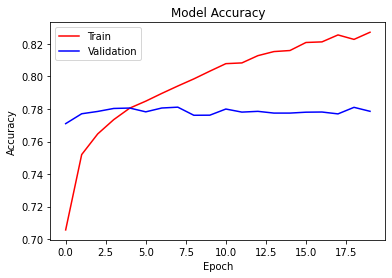

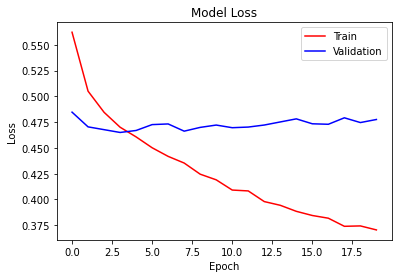

In [0]:
# Evaluate model
accuracy_loss_evaluation(d_model)
# Plot accuracy during training
plot_history_accuracy(history_d)
# Plot loss during training
plot_history_loss(history_d)

### Implement MLP with different optimisers

In [0]:
# Define MLP function that can pass different optimisers in
def different_optimiser(optimiser = 'adam', n_epochs = 20, batch_size = 128):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = 100, trainable = False))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'sigmoid'))
  model.compile(optimizer = optimiser, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                            validation_data = (valid_seq, validation_label), verbose = 1)
  loss, accuracy = model.evaluate(test_seq, test_label, verbose = 1)
  return model, history, loss, accuracy

In [0]:
# Train models with different optimisers
model_rmsprop, history_rmsprop, loss_rmsprop, acc_rmsprop = different_optimiser('rmsprop') # Root mean square propagation
model_adagrad, history_adagrad, loss_adagrad, acc_adagrad = different_optimiser('adagrad') # Adaptive gradient algorithm
model_adam, history_adam, loss_adam, acc_adam = different_optimiser('adam')                # Adam

Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 4s 60us/step - loss: 0.5670 - accuracy: 0.7040 - val_loss: 0.4962 - val_accuracy: 0.7681
Epoch 2/20
73067/73067 [==============================] - 4s 60us/step - loss: 0.5084 - accuracy: 0.7523 - val_loss: 0.4812 - val_accuracy: 0.7740
Epoch 3/20
73067/73067 [==============================] - 4s 59us/step - loss: 0.4836 - accuracy: 0.7645 - val_loss: 0.4682 - val_accuracy: 0.7818
Epoch 4/20
73067/73067 [==============================] - 4s 58us/step - loss: 0.4669 - accuracy: 0.7767 - val_loss: 0.4720 - val_accuracy: 0.7779
Epoch 5/20
73067/73067 [==============================] - 4s 58us/step - loss: 0.4524 - accuracy: 0.7854 - val_loss: 0.4698 - val_accuracy: 0.7820
Epoch 6/20
73067/73067 [==============================] - 4s 59us/step - loss: 0.4389 - accuracy: 0.7949 - val_loss: 0.4680 - val_accuracy: 0.7835
Epoch 7/20
73067/73067 [==============================] - 4s 58us/st

In [0]:
# Print model accuracy and loss
optimiser_list = ['rmsprop', 'adagrad', 'adam']
opt_index_names = ['RmsProp', 'AdaGrad', 'Adam']
optimiser_loss = [loss_rmsprop, loss_adagrad, loss_adam]
optimiser_acc = [acc_rmsprop, acc_adagrad, acc_adam]
optimiser_df = pd.DataFrame(index = opt_index_names, columns = ['Testing Accuracy', 'Testing Loss'])
for i in range(len(optimiser_list)):
  optimiser_df.iloc[i, ] = [optimiser_acc[i], optimiser_loss[i]]

print(optimiser_df)

        Testing Accuracy Testing Loss
RmsProp         0.781773     0.500891
AdaGrad         0.790335     0.455012
Adam            0.788167     0.466988


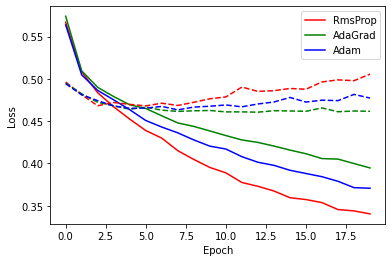

In [0]:
# Plot accuracy and loss during training for each optimiser
plt.plot(history_rmsprop.history['loss'], 'r', label = 'RmsProp')
plt.plot(history_adagrad.history['loss'], 'g', label = 'AdaGrad')
plt.plot(history_adam.history['loss'], 'b', label = 'Adam')
plt.plot(history_rmsprop.history['val_loss'], 'r', linestyle = '--')
plt.plot(history_adagrad.history['val_loss'], 'g', linestyle = '--')
plt.plot(history_adam.history['val_loss'], 'b', linestyle = '--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.show()

### RNN with LSTM

In [0]:
# Define a RNN with LSTM network function
def LSTM_model(review_length = 100, embedding_dim = 100, lstm_output = 128):
  model = Sequential()
  e = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = review_length)
  model.add(e)
  model.add(LSTM(lstm_output, dropout_U = 0.2, dropout_W = 0.2))      # LSTM layer
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'sigmoid'))
  return model

#### Tuning LSTM output dimension

In [0]:
# Define function for model with LSTM output dimension as input
def different_output_dim(lstm_dim):
  lstm_model = LSTM_model(lstm_output = lstm_dim)
  lstm_model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])
  n_epochs = 10
  batch_size = 128
  cp_callback_lstm = callback_best_model('LSTM-model/lstm-{epoch:02d}-{loss:.4f}.hdf5')
  history_lstm = lstm_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_lstm])
  lstm_loss_train, lstm_acc_train, lstm_loss_valid, lstm_acc_valid, lstm_loss_test, lstm_acc_test = accuracy_loss_evaluation(lstm_model)
  plot_history_accuracy(history_lstm)
  plot_history_loss(history_lstm)
  return lstm_loss_test, lstm_acc_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`
  """
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 108s 1ms/step - loss: 0.4068 - accuracy: 0.8176 - val_loss: 0.3177 - val_accuracy: 0.8658

Epoch 00001: val_loss improved from inf to 0.31775, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-01-0.4068.hdf5
Epoch 2/10
73067/73067 [==============================] - 107s 1ms/step - loss: 0.3150 - accuracy: 0.8684 - val_loss: 0.2851 - val_accuracy: 0.8796

Epoch 00002: val_loss improved from 0.31775 to 0.28507, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-02-0.3150.hdf5
Epoch 3/10
73067/73067 [==============================] - 108s 1ms/step - loss: 0.2828 - accuracy: 0.8840 - val_loss: 0.2751 - val_accuracy: 0.8860

Epoch 00003: val_loss improved from 0.28507 to 0.27513, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-03-0.2828.hdf5
Epoch 4/10
73067/73067 [==============================] - 109s 1ms/step - l

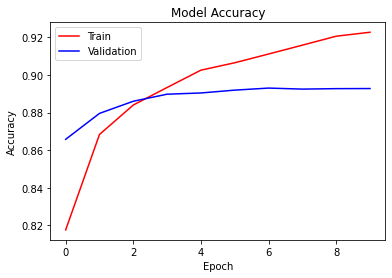

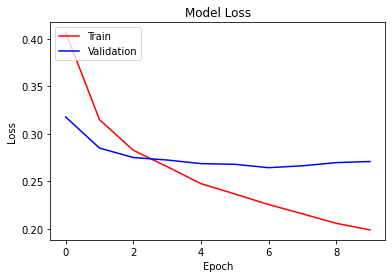

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  """


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 167s 2ms/step - loss: 0.3969 - accuracy: 0.8224 - val_loss: 0.3018 - val_accuracy: 0.8761

Epoch 00001: val_loss improved from inf to 0.30178, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-01-0.3969.hdf5
Epoch 2/10
73067/73067 [==============================] - 165s 2ms/step - loss: 0.3001 - accuracy: 0.8757 - val_loss: 0.2761 - val_accuracy: 0.8853

Epoch 00002: val_loss improved from 0.30178 to 0.27615, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-02-0.3001.hdf5
Epoch 3/10
73067/73067 [==============================] - 165s 2ms/step - loss: 0.2701 - accuracy: 0.8901 - val_loss: 0.2682 - val_accuracy: 0.8903

Epoch 00003: val_loss improved from 0.27615 to 0.26817, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-03-0.2701.hdf5
Epoch 4/10
73067/73067 [==============================] - 165s 2ms/step - l

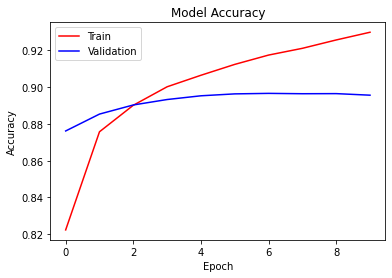

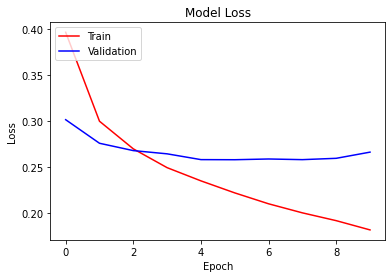

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, dropout=0.2, recurrent_dropout=0.2)`
  """


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 247s 3ms/step - loss: 0.3965 - accuracy: 0.8218 - val_loss: 0.2962 - val_accuracy: 0.8747

Epoch 00001: val_loss improved from inf to 0.29619, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-01-0.3965.hdf5
Epoch 2/10
73067/73067 [==============================] - 246s 3ms/step - loss: 0.2895 - accuracy: 0.8800 - val_loss: 0.2694 - val_accuracy: 0.8892

Epoch 00002: val_loss improved from 0.29619 to 0.26939, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-02-0.2895.hdf5
Epoch 3/10
73067/73067 [==============================] - 247s 3ms/step - loss: 0.2592 - accuracy: 0.8950 - val_loss: 0.2618 - val_accuracy: 0.8931

Epoch 00003: val_loss improved from 0.26939 to 0.26179, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-03-0.2592.hdf5
Epoch 4/10
73067/73067 [==============================] - 247s 3ms/step - l

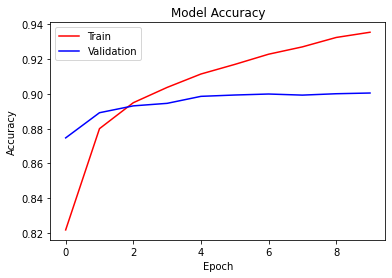

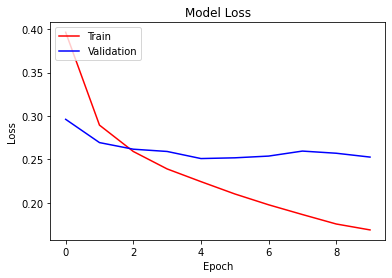

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, dropout=0.2, recurrent_dropout=0.2)`
  """


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 364s 5ms/step - loss: 0.4339 - accuracy: 0.7921 - val_loss: 0.2963 - val_accuracy: 0.8786

Epoch 00001: val_loss improved from inf to 0.29626, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-01-0.4339.hdf5
Epoch 2/10
73067/73067 [==============================] - 362s 5ms/step - loss: 0.2872 - accuracy: 0.8795 - val_loss: 0.2791 - val_accuracy: 0.8835

Epoch 00002: val_loss improved from 0.29626 to 0.27913, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-02-0.2872.hdf5
Epoch 3/10
73067/73067 [==============================] - 361s 5ms/step - loss: 0.2554 - accuracy: 0.8957 - val_loss: 0.2603 - val_accuracy: 0.8934

Epoch 00003: val_loss improved from 0.27913 to 0.26026, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm-03-0.2554.hdf5
Epoch 4/10
73067/73067 [==============================] - 361s 5ms/step - l

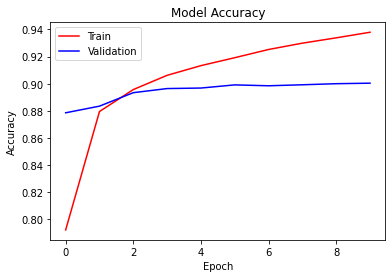

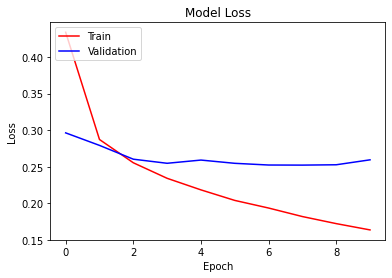

In [0]:
# Create a list of LSTM model output dimension
lstm_dim_list = [64, 128, 256, 512]

# Train the models
lstm_loss_test_list = []
lstm_acc_test_list = []
for dim in lstm_dim_list:
  loss_test, acc_test = different_output_dim(dim)
  lstm_loss_test_list.append(loss_test)
  lstm_acc_test_list.append(acc_test)

In [0]:
# Print model accuracy and loss
index_names = ['Dim 64', 'Dim 128', 'Dim 256', 'Dim 512']
lstm_dim_df = pd.DataFrame(columns = ['Testing Accuracy', 'Testing Loss'], index = index_names)
for i in range(len(index_names)):
  lstm_dim_df.iloc[i, ] = [lstm_acc_test_list[i], lstm_loss_test_list[i]]

print(lstm_dim_df)

        Testing Accuracy Testing Loss
Dim 64          0.888697     0.281951
Dim 128         0.892091     0.276355
Dim 256         0.896623     0.260134
Dim 512         0.897762      0.26917


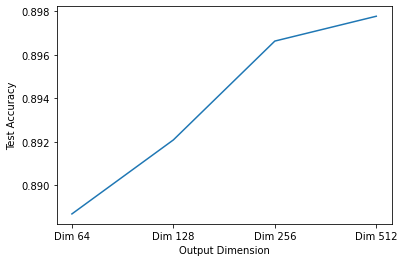

In [0]:
# Plot the testing accuracy versus output dimension
plt.plot(lstm_dim_df['Testing Accuracy'])
plt.ylabel('Test Accuracy')
plt.xlabel('Output Dimension')
plt.show()

Text(0.5, 0, 'Output Dimension')

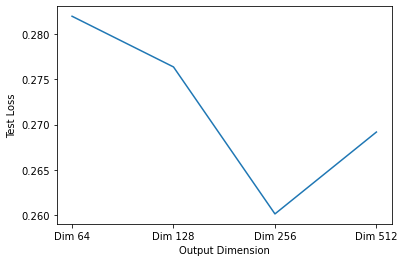

In [0]:
# Plot the loss versus output dimension
plt.plot(lstm_dim_df['Testing Loss'])
plt.ylabel('Test Loss')
plt.xlabel('Output Dimension')
plt.show()

#### Run the model for LSTM output dimension 512

In [0]:
# Create a basic model instance
lstm_model = LSTM_model(lstm_output = 512)

# compile the model
lstm_model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(lstm_model.summary())

# Define hyperparameters
n_epochs = 10
batch_size = 128

# Create model checkpoint to save model
cp_callback_lstm = callback_best_model('LSTM-model/lstm512-{epoch:02d}-{loss:.4f}.hdf5')

# Train the model with the new callback
history_lstm = lstm_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_lstm])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, dropout=0.2, recurrent_dropout=0.2)`
  """


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          5635700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 6,892,150
Trainable params: 6,892,150
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 373s 5ms/step - loss: 0.4743 - accuracy: 0.7621 - val_loss: 0.3032 - val_accuracy: 0.8726

Epoch 00001: val_loss improved from inf to 0.30321, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm512-01-0.4743.hdf5
Epoch 2/10
73067/73067 [==============================] - 375s 5ms/step - loss: 0.2949 - accuracy: 0.8773 - val_loss: 0.2746 - val_accuracy: 0.8861

Epoch 00002: val_loss improved from 0.30321 to 0.27456, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm512-02-0.2949.hdf5
Epoch 3/10
73067/73067 [==============================] - 382s 5ms/step - loss: 0.2578 - accuracy: 0.8944 - val_loss: 0.2594 - val_accuracy: 0.8914

Epoch 00003: val_loss improved from 0.27456 to 0.25942, saving model to /content/gdrive/My Drive/ST449-two-class/LSTM-model/lstm512-03-0.2578.hdf5
Epoch 4/10
73067/73067 [==============================] - 381s 5ms

22834/22834 [==============================] - 83s 4ms/step
Training accuracy: 95.39%, training loss:  0.13
Validation accuracy: 90.17%, validation loss:  0.25
Test accuracy: 89.71%, test loss:  0.26


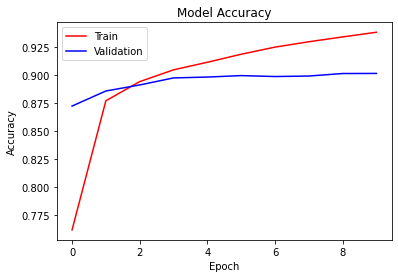

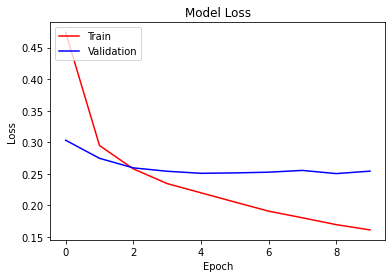

In [0]:
# Evaluate the model
lstm_loss_train, lstm_acc_train, lstm_loss_valid, lstm_acc_valid, lstm_loss_test, lstm_acc_test = accuracy_loss_evaluation(lstm_model)
# Plot accuracy during training
plot_history_accuracy(history_lstm)
# Plot loss during training
plot_history_loss(history_lstm)

### RNN with bidirectional LSTM

In [0]:
# Define model structure
def bidirection_LSTM_model(review_length = 100, embedding_dim = 100, lstm_output = 512):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = review_length))
  model.add(Bidirectional(LSTM(lstm_output, dropout_U = 0.2,dropout_W = 0.2)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.001)))
  return model

In [0]:
# Create a basic model instance
bi_lstm_model = bidirection_LSTM_model()

# compile the model
bi_lstm_model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(bi_lstm_model.summary())

# Define hyperparameters
n_epochs = 10
batch_size = 128

# Create model checkpoint to save model
cp_callback_bi_lstm = callback_best_model('bidirectionalLSTM/adam-{epoch:02d}-{loss:.4f}.hdf5')

# Train the model with the new callback
history_bi_lstm = bi_lstm_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_bi_lstm])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          5635700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2510848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 8,148,598
Trainable params: 8,148,598
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/10
73067/73067 [==============================] - 555s 8ms/step - loss: 0.4174 - accuracy: 0.8130 - val_loss: 0.3053 - val_accuracy: 0.8741

Epoch 00001: val_loss improved from inf to 0.30533, saving model to /content/gdrive/My Drive/ST449-two-class/bidirectionalLSTM/adam-01-0.4174.hdf5
Epoch 2/10
73067/73067 [==============================] - 574s 8ms/step - loss: 0.2925 - accuracy: 0.8794 - val_loss: 0.2720 - val_accuracy: 0.8897

Epoch 00002: val_loss improved from 0.30533 to 0.27201, saving model to /content/gdrive/My Drive/ST449-two-class/bidirectionalLSTM/adam-02-0.2925.hdf5
Epoch 3/10
73067/73067 [==============================] - 562s 8ms/step - loss: 0.2574 - accuracy: 0.8969 - val_loss: 0.2647 - val_accuracy: 0.8934

Epoch 00003: val_loss improved from 0.27201 to 0.26466, saving model to /content/gdrive/My Drive/ST449-two-class/bidirectionalLSTM/adam-03-0.2574.hdf5
Epoch 4/10
73067/73067 [==============================

22834/22834 [==============================] - 115s 5ms/step
Training accuracy: 95.32%, training loss:  0.13
Validation accuracy: 90.14%, validation loss:  0.26
Test accuracy: 89.86%, test loss:  0.27


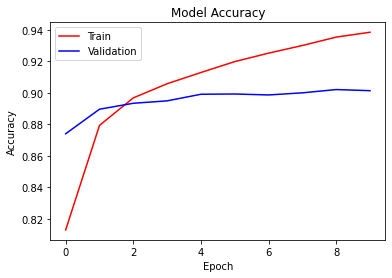

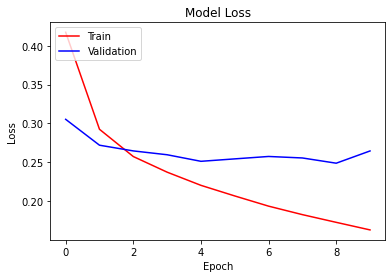

In [0]:
# Evaluate the model
bi_lstm_loss_train, bi_lstm_acc_train, bi_lstm_loss_valid, bi_lstm_acc_valid, bi_lstm_loss_test, bi_lstm_acc_test = accuracy_loss_evaluation(bi_lstm_model)
# Plot accuracy during training
plot_history_accuracy(history_bi_lstm)
# Plot loss during training
plot_history_loss(history_bi_lstm)

### CNN

In [0]:
# Define model structure
def TextCNN_model(review_length, num_classes, vocab_size, embedding_dim,
                  filter_sizes, num_filters, dropout_size = 0.5, reg_lambda = 0.0):

  # Embedding
  input_data = keras.layers.Input(shape = (review_length, ), name = 'input_data')
  embedding = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = review_length, name = 'embedding')(input_data)

  embedding = keras.layers.Reshape((review_length, embedding_dim, 1))(embedding)

  # Max-pooling
  pool_outputs = []
  for i, filter_size in enumerate(filter_sizes):
    filter_shape = (filter_size, embedding_dim)
    conv = Conv2D(num_filters, filter_shape, strides = (1, 1), padding = 'valid',
                  activation = 'relu', kernel_initializer = 'glorot_normal',
                  bias_initializer = keras.initializers.constant(0.1),
                  name = 'conv_{:d}'.format(filter_size))(embedding)
    max_pool_shape = (review_length - filter_size + 1, 1)
    max_pool = MaxPool2D(pool_size = max_pool_shape, strides = (1, 1), padding = 'valid',
                         name = 'maxpooling_{:d}'.format(filter_size))(conv)
    pool_outputs.append(max_pool)

  # Pool output processing
  pool_concate = keras.layers.concatenate(pool_outputs, axis = -1, name = 'concatenation')
  pool_flattern = Flatten(name = 'flatten')(pool_concate)
  pool_dropout = Dropout(dropout_size, name = 'dropout')(pool_flattern)

  # Outputs
  outputs = Dense(num_classes, activation = 'softmax', 
                 kernel_initializer = 'glorot_normal',
                 bias_initializer = keras.initializers.constant(0.1),
                 kernel_regularizer = keras.regularizers.l2(reg_lambda),
                 bias_regularizer = keras.regularizers.l2(reg_lambda),
                 name = 'output')(pool_dropout)
  
  model = keras.Model(inputs = input_data, outputs = outputs)

  return model


In [0]:
# Define hyperparameters
review_length = 100
num_classes = 2
filter_sizes = (3, 4, 5)
num_filters = 128
embedding_dim = 100

# Create a basic model instance
textcnn_model = TextCNN_model(100, 2, vocab_size, embedding_dim, filter_sizes = filter_sizes, 
                              num_filters = num_filters, reg_lambda = 3.0)
# Compile the model
textcnn_model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(textcnn_model.summary())

# Define hyperparameters
n_epochs = 20
batch_size = 50

# Create model checkpoint to save model
cp_callback_textcnn = callback_best_model('TextCNN-model/filters128-{epoch:02d}-{val_accuracy:.4f}.hdf5')

# Train the model
history_textcnn = textcnn_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_textcnn])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     5635700     input_data[0][0]                 
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 100, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 98, 1, 128)   38528       reshape_3[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 49s 672us/step - loss: 0.5765 - accuracy: 0.8191 - val_loss: 0.3916 - val_accuracy: 0.8560

Epoch 00001: val_loss improved from inf to 0.39157, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters128-01-0.8560.hdf5
Epoch 2/20
73067/73067 [==============================] - 49s 675us/step - loss: 0.3730 - accuracy: 0.8634 - val_loss: 0.3626 - val_accuracy: 0.8658

Epoch 00002: val_loss improved from 0.39157 to 0.36256, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters128-02-0.8658.hdf5
Epoch 3/20
73067/73067 [==============================] - 49s 674us/step - loss: 0.3426 - accuracy: 0.8766 - val_loss: 0.3504 - val_accuracy: 0.8689

Epoch 00003: val_loss improved from 0.36256 to 0.35039, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters128-03-0.8689.hdf5
Epoch 4/20
73067/73067 [=====================

22834/22834 [==============================] - 2s 103us/step
Training accuracy: 93.61%, training loss:  0.21
Validation accuracy: 88.82%, validation loss:  0.30
Test accuracy: 88.67%, test loss:  0.31


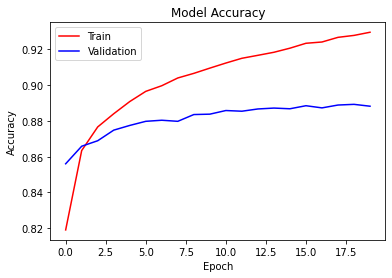

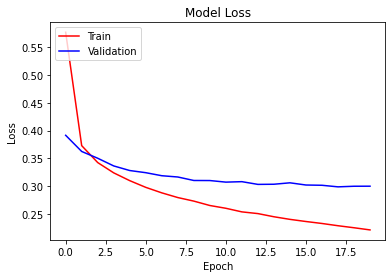

In [0]:
# Evaluate model
textcnn_loss_train, textcnn_acc_train, textcnn_loss_valid, textcnn_acc_valid, textcnn_loss_test, textcnn_acc_test = accuracy_loss_evaluation(textcnn_model)
# Plot accuracy during training
plot_history_accuracy(history_textcnn)
# Plot loss during training
plot_history_loss(history_textcnn)

#### Change number of filters in CNN to 256

In [0]:
# Create a basic model instance
textcnn_model = TextCNN_model(100, 2, vocab_size, 100, filter_sizes = (3, 4, 5), 
                              num_filters = 256, reg_lambda = 3.0)
# compile the model
textcnn_model.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(textcnn_model.summary())

# Define hyperparameters
n_epochs = 20
batch_size = 50

# Create checkpoint to save model
cp_callback_textcnn = callback_best_model('TextCNN-model/filters256-{epoch:02d}-{val_accuracy:.4f}.hdf5')

# Train the model
history_textcnn = textcnn_model.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_textcnn])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     5635700     input_data[0][0]                 
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 100, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 98, 1, 256)   77056       reshape_2[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 59s 804us/step - loss: 0.5245 - accuracy: 0.8235 - val_loss: 0.4024 - val_accuracy: 0.8428

Epoch 00001: val_loss improved from inf to 0.40237, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters256-01-0.8428.hdf5
Epoch 2/20
73067/73067 [==============================] - 59s 809us/step - loss: 0.3607 - accuracy: 0.8685 - val_loss: 0.3550 - val_accuracy: 0.8680

Epoch 00002: val_loss improved from 0.40237 to 0.35496, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters256-02-0.8680.hdf5
Epoch 3/20
73067/73067 [==============================] - 59s 804us/step - loss: 0.3311 - accuracy: 0.8808 - val_loss: 0.3551 - val_accuracy: 0.8622

Epoch 00003: val_loss did not improve from 0.35496
Epoch 4/20
73067/73067 [==============================] - 59s 801us/step - loss: 0.3113 - accuracy: 0.8898 - val_loss: 0.3362 - val_accuracy: 0.872

22834/22834 [==============================] - 3s 132us/step
Training accuracy: 93.94%, training loss:  0.20
Validation accuracy: 88.59%, validation loss:  0.31
Test accuracy: 88.57%, test loss:  0.31


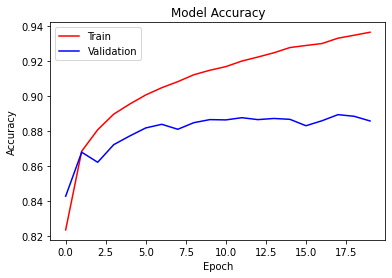

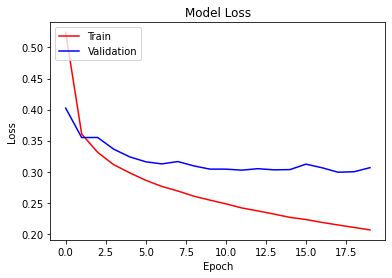

In [0]:
# Evaluate model
textcnn_loss_train, textcnn_acc_train, textcnn_loss_valid, textcnn_acc_valid, textcnn_loss_test, textcnn_acc_test = accuracy_loss_evaluation(textcnn_model)
# Plot accuracy during training
plot_history_accuracy(history_textcnn)
# Plot loss during training
plot_history_loss(history_textcnn)

#### Change the filter size to be 5,6 and 7

In [0]:
# Create a basic model instance
textcnn_model_filter = TextCNN_model(100, 2, vocab_size, 100, filter_sizes = (5, 6, 7), 
                              num_filters = 128, reg_lambda = 3.0)
# compile the model
textcnn_model_filter.compile(optimizer = 'adagrad', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Display the model's architecture
print(textcnn_model_filter.summary())

# Define hyperparameters
n_epochs = 20
batch_size = 50

# Create checkpoint to save model
cp_callback_textcnn_filter = callback_best_model('TextCNN-model/filters-size567-{epoch:02d}-{val_accuracy:.4f}.hdf5')

# Train the model
history_textcnn_filter = textcnn_model_filter.fit(train_seq, train_label,  epochs = n_epochs, batch_size = batch_size,
                              validation_data = (valid_seq, validation_label), verbose = 1, callbacks = [cp_callback_textcnn_filter])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     5635700     input_data[0][0]                 
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 100, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_5 (Conv2D)                 (None, 96, 1, 128)   64128       reshape_4[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 73067 samples, validate on 18267 samples
Epoch 1/20
73067/73067 [==============================] - 55s 759us/step - loss: 0.5626 - accuracy: 0.8258 - val_loss: 0.3798 - val_accuracy: 0.8615

Epoch 00001: val_loss improved from inf to 0.37983, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters-size567-01-0.8615.hdf5
Epoch 2/20
73067/73067 [==============================] - 55s 752us/step - loss: 0.3589 - accuracy: 0.8700 - val_loss: 0.3519 - val_accuracy: 0.8672

Epoch 00002: val_loss improved from 0.37983 to 0.35192, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters-size567-02-0.8672.hdf5
Epoch 3/20
73067/73067 [==============================] - 55s 754us/step - loss: 0.3313 - accuracy: 0.8804 - val_loss: 0.3425 - val_accuracy: 0.8700

Epoch 00003: val_loss improved from 0.35192 to 0.34246, saving model to /content/gdrive/My Drive/ST449-two-class/TextCNN-model/filters-size567-03-0.8700.hdf5
Epoch 4/20
73067/73067 [======

22834/22834 [==============================] - 2s 104us/step
Training accuracy: 93.76%, training loss:  0.20
Validation accuracy: 88.63%, validation loss:  0.30
Test accuracy: 88.84%, test loss:  0.31


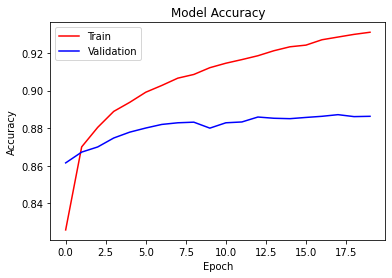

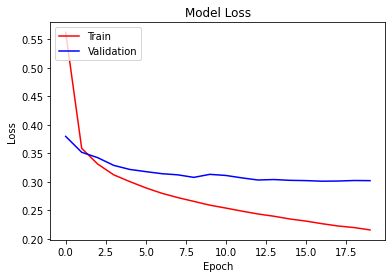

In [0]:
# Evaluate the model
accuracy_loss_evaluation(textcnn_model_filter)
# Plot accuracy during training
plot_history_accuracy(history_textcnn_filter)
# Plot loss during training
plot_history_loss(history_textcnn_filter)

## Model Assessment

In [0]:
# Define function for plotting ROC curve
def plot_ROC(testY, prediction_prob):
  fpr, tpr, threshold = roc_curve(testY, prediction_prob)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

#### ROC for RNN with LSTM(512)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     11264
           1       0.90      0.90      0.90     11570

    accuracy                           0.90     22834
   macro avg       0.90      0.90      0.90     22834
weighted avg       0.90      0.90      0.90     22834



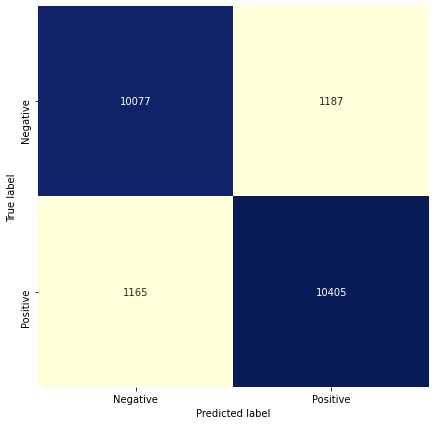

In [0]:
# Evaluate outputs as probabilities
lstm_prob = lstm_model.predict(test_seq)

# Metric summary statistics
print(classification_report(test_label.argmax(axis=1), lstm_prob.argmax(axis=1)))

# Create confusion matrix
lstm_map = confusion_matrix(test_label.argmax(axis=1), lstm_prob.argmax(axis=1))
# Plot confusion matrix
plot_confusion_matrix(lstm_map)

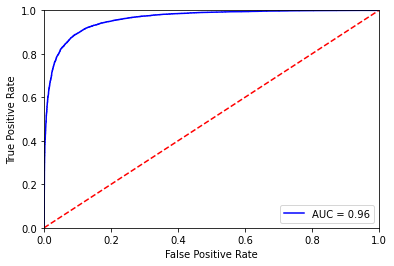

In [0]:
# Plot ROC curve
lstm_prediction_prob = lstm_prob[:,1]
plot_ROC(testY, lstm_prediction_prob)

#### ROC for RNN with bidirectional LSTM model

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     11264
           1       0.89      0.91      0.90     11570

    accuracy                           0.90     22834
   macro avg       0.90      0.90      0.90     22834
weighted avg       0.90      0.90      0.90     22834



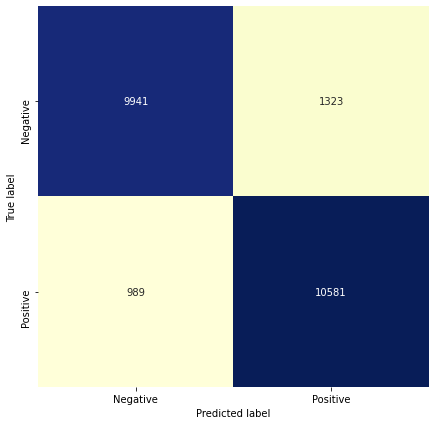

In [0]:
# Evaluate outputs as probabilities
bi_lstm_prob = bi_lstm_model.predict(test_seq)

# Metric summary statistics
print(classification_report(test_label.argmax(axis=1), bi_lstm_prob.argmax(axis=1)))

# Create confusion matrix
bi_lstm_map = confusion_matrix(test_label.argmax(axis=1), bi_lstm_prob.argmax(axis=1))
# Plot confusion matrix
plot_confusion_matrix(bi_lstm_map)

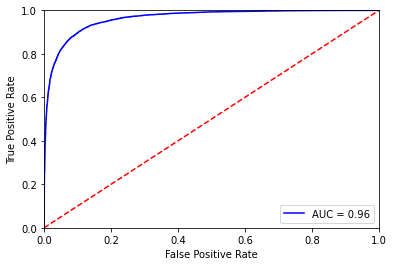

In [0]:
# Plot ROC curve
bi_lstm_prediction_prob = bi_lstm_prob[:,1]
plot_ROC(testY, bi_lstm_prediction_prob)

#### ROC for CNN with filter sizes (5,6,7)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11264
           1       0.90      0.88      0.89     11570

    accuracy                           0.89     22834
   macro avg       0.89      0.89      0.89     22834
weighted avg       0.89      0.89      0.89     22834



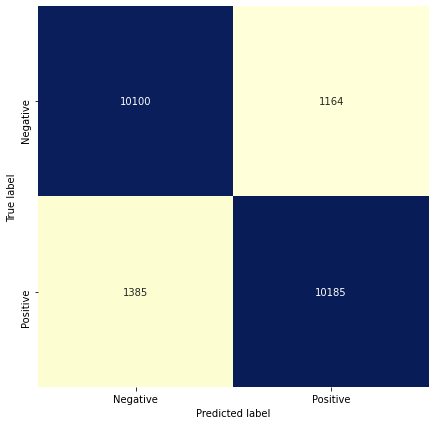

In [0]:
# Evaluate outputs as probabilities
textcnn_prob = textcnn_model_filter.predict(test_seq)

# Metric summary statistics
print(classification_report(test_label.argmax(axis=1), textcnn_prob.argmax(axis=1)))

# Create confusion matrix
textcnn_map = confusion_matrix(test_label.argmax(axis=1), textcnn_prob.argmax(axis=1))
# Plot confusion matrix
plot_confusion_matrix(textcnn_map)

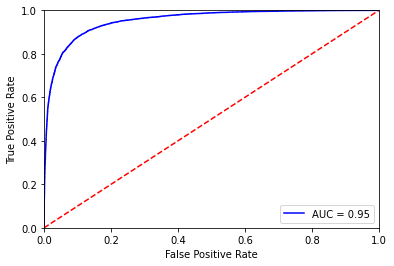

In [0]:
# Plot ROC
textcnn_prediction_prob = textcnn_prob[:,1]
plot_ROC(testY, textcnn_prediction_prob)